In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from htc_projects.sepsis_icu.settings_sepsis_icu import settings_sepsis_icu
from htc_projects.sepsis_icu.tables import first_inclusion
from htc_projects.sepsis_icu.utils import save_figure, target_to_label

In [2]:
plt.rcParams["font.family"] = settings_sepsis_icu.font_family
plt.rcParams["font.sans-serif"] = settings_sepsis_icu.font
plt.rcParams["font.size"] = settings_sepsis_icu.font_size
plt.rcParams["xtick.labelsize"] = settings_sepsis_icu.font_size
plt.rcParams["ytick.labelsize"] = settings_sepsis_icu.font_size

In [3]:
def plot_spectra(target: str) -> None:
    target_label = target_to_label(target)
    if target == "shock":
        base_name = "sepsis"
    else:
        base_name = target
    df = first_inclusion(base_name)

    # only show shock vs no shock for septic patients
    if target == "shock":
        df = df[df["sepsis_status"] == "sepsis"]
        mapping = {
            True: "shock",
            False: "no_shock",
        }
        df[target_label] = df[target_label].map(mapping)
        palette = settings_sepsis_icu.shock_colors
    elif target == "survival":
        mapping = {
            True: "survivor",
            False: "non-survivor",
        }
        df[target_label] = df[target_label].map(mapping)
        palette = settings_sepsis_icu.survival_colors
    else:
        palette = settings_sepsis_icu.disease_colors

    fig, ax = plt.subplots(
        1, 2, figsize=(settings_sepsis_icu.page_width_inch, 2.5), sharey=True, constrained_layout=True
    )

    legend_handles = []
    legend_names = []

    for i, label_name in enumerate(["palm", "finger"]):
        df_ms = df.query("label_name == @label_name")

        for status in df_ms[target_label].unique():
            df_status = df_ms[df_ms[target_label] == status]
            median_spec = np.mean(np.stack(df_status.median_normalized_spectrum), axis=0)
            std_spec = np.std(np.stack(df_status.median_normalized_spectrum), axis=0)

            p1 = ax[i].plot(
                np.linspace(500, 1000, 100),
                median_spec,
                label=label_name,
                color=palette[status],
            )
            p2 = ax[i].fill_between(
                np.linspace(500, 1000, 100),
                median_spec - std_spec,
                median_spec + std_spec,
                alpha=0.3,
                color=palette[status],
            )
            if i == 0:
                legend_handles.append((p1[0], p2))
                legend_names.append(status.replace("_", " "))

        ax[i].set_xlabel("wavelength [nm]", fontsize=settings_sepsis_icu.font_size)
        ax[i].set_title(label_name)
        ax[i].grid(True, linestyle="dotted")

    ax[0].set_ylabel("normalized\nreflectance [a.u.]", fontsize=settings_sepsis_icu.font_size)

    legend = fig.legend(
        legend_handles,
        legend_names,
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(df_ms[target_label].unique()),
    )

    savepath = settings_sepsis_icu.results_dir / "paper_figures" / f"Spectra_{target}.pdf"
    savepath.parent.mkdir(parents=True, exist_ok=True)
    save_figure(savepath, fig, dpi=300, bbox_inches="tight")

[WARNING][htc] The width of the figure Spectra_sepsis.pdf is 18.711 cm instead of 18.415 cm (-3.711         utils.py:208
missing)                                                                                                                

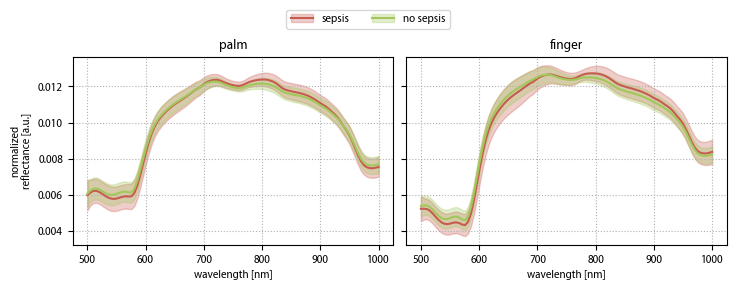

In [4]:
plot_spectra("sepsis")

[WARNING][htc] The width of the figure Spectra_survival.pdf is 18.711 cm instead of 18.415 cm (-3.711       utils.py:208
missing)                                                                                                                

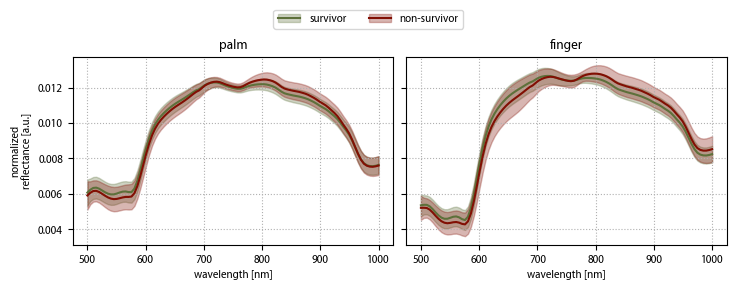

In [5]:
plot_spectra("survival")